In [1]:
from datetime import datetime,timedelta
from scipy.stats import iqr,skew,kurtosis,mode
from joblib import Parallel,delayed
import zipfile
import shutil
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.decomposition import PCA
from pprint import pprint
from sklearn.metrics import f1_score,r2_score,classification_report
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
import itertools
from sklearn.model_selection import ParameterGrid, cross_val_predict, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
seed = 100
tf.random.set_seed(seed)
np.random.seed(seed)
import os
import pandas as pd
import pickle
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split,LeavePGroupsOut
from keras.backend import expand_dims, repeat_elements
from keras.layers import Lambda
from tensorflow.keras.layers import Conv1D,BatchNormalization,Dropout,InputLayer,MaxPooling1D,Flatten,RepeatVector,Dense,Input,Activation,GRU,Bidirectional,LSTM
from tensorflow.keras.models import Model, Sequential
from sklearn.metrics import accuracy_score
import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

/home/azim/miniconda3/envs/test1/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210310). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


4 Physical GPUs, 1 Logical GPU


In [86]:
def get_X_y_groups(n_lag=10):
    data = pickle.load(open('./data/episode_encoded_lagged_data/episode_encoded_lagged_'+str(n_lag)+'_windows_standardized.p','rb'))

    X_feature = np.concatenate(data.feature_final.values)
    X_static =  np.concatenate(data.static_features.values)

    X_stress_episode = np.concatenate(data.stress_episode.values)
    X_quit_episode = np.concatenate(data.quit_episode.values)
    X_activity_episode = np.concatenate(data.activity_episode.values)
    X_smoking_episode = np.concatenate(data.smoking_episode.values)

    y_time = data['time'].values
    y = data['label'].values
    groups = data['user'].values
    
    return X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups


def get_train_test_indexes(groups,n_groups_split = 10,n_val_groups = 5):
    groups_unique = np.unique(groups)
    groups_split = np.array_split(groups_unique,n_groups_split)
    indexes = []
    for this_groups in groups_split:
        train_groups = np.array([a for a in groups_unique if a not in this_groups])
        val_groups = np.random.choice(train_groups,n_val_groups)
        train_groups = np.array([a for a in groups_unique if a not in list(this_groups)+list(val_groups)])
        test_groups = this_groups
        train_index,test_index = np.array([i for i,a in enumerate(groups) 
                                           if a in train_groups]),np.array([i for i,a in enumerate(groups) 
                                                                               if a in test_groups])
        val_index = np.array([i for i,a in enumerate(groups) 
                                           if a in val_groups])
        indexes.append([train_index,test_index,val_index])
    return indexes


from sklearn import metrics
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = metrics.precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .7
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and recall[i]>min_recall:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1


def get_model():
    n_t,n_f = train_feature.shape[1],train_feature.shape[2]
#     print(n_t,n_f)
    x_input = Input(shape=(n_t,n_f))
    x_feature = Conv1D(100,1,activation='linear')(x_input)
    x_feature = Conv1D(100,1,activation='tanh')(x_feature)
    x_feature = Dropout(.2)(x_feature)
    x_feature = LSTM(20,activation='tanh',return_sequences=False)(x_feature)
    x_feature = Dropout(.3)(x_feature)
    x_feature = Flatten()(x_feature)
    x_feature = Dense(10,activation='relu')(x_feature)
    # x_final = Dense(1,activation='sigmoid')(x_feature)

    n_sf = train_static.shape[1]
    x_input_static = Input(shape=(n_sf))
    x_static = Dense(100,activation='relu')(x_input_static)
    x_static = Dense(10,activation='relu')(x_static)
    n_timesteps = train_stress.shape[-2]
    n_episodes_stress,n_episodes_quit,n_episodes_activity,n_episodes_smoking = train_stress.shape[1],train_quit.shape[1],train_activity.shape[1],train_smoking.shape[1]
    x_alpha_stress = Dense(1,activation='sigmoid')(x_static)
    x_alpha_stress = RepeatVector(n_timesteps)(x_alpha_stress)
    x_alpha_stress = Lambda(lambda x: repeat_elements(expand_dims(x, axis=1), n_episodes_stress, 1))(x_alpha_stress)
    x_alpha_quit = Dense(1,activation='sigmoid')(x_static)
    x_alpha_quit = RepeatVector(n_timesteps)(x_alpha_quit)
    x_alpha_quit = Lambda(lambda x: repeat_elements(expand_dims(x, axis=1), n_episodes_quit, 1))(x_alpha_quit)
    x_alpha_activity = Dense(1,activation='sigmoid')(x_static)
    x_alpha_activity = RepeatVector(n_timesteps)(x_alpha_activity)
    x_alpha_activity = Lambda(lambda x: repeat_elements(expand_dims(x, axis=1), n_episodes_activity, 1))(x_alpha_activity)
    x_alpha_smoking = Dense(1,activation='sigmoid')(x_static)
    x_alpha_smoking = RepeatVector(n_timesteps)(x_alpha_smoking)
    x_alpha_smoking = Lambda(lambda x: repeat_elements(expand_dims(x, axis=1), n_episodes_smoking, 1))(x_alpha_smoking)

    n_dim = 3
    x_stress = Input(shape=(n_episodes_stress,n_timesteps,n_dim))
    stress_alpha_time = tf.math.multiply(x_alpha_stress[:,:,:,0]*-1,x_stress[:,:,:,0])
    stress_alpha_time_exp = tf.math.exp(stress_alpha_time)

    x_stress_amplitude = x_stress[:,:,:,1]
    stress_amplitude_coeff = Dense(1,activation='sigmoid')(x_feature)
    stress_amplitude_coeff = Lambda(lambda x: expand_dims(x, axis=2))(stress_amplitude_coeff)
    print(stress_amplitude_coeff.shape,'coeff',x_stress_amplitude.shape,'amplitude')
    x_stress_amplitude = tf.math.multiply(x_stress_amplitude,stress_amplitude_coeff)
#     print(x_stress_amplitude.shape,'final')
    
    x_stress_duration = x_stress[:,:,:,2]
    stress_duration_coeff = Dense(1,activation='sigmoid')(x_feature)
    stress_duration_coeff = Lambda(lambda x: expand_dims(x, axis=2))(stress_duration_coeff)
    x_stress_duration = tf.math.multiply(x_stress_duration,stress_duration_coeff)
    
    x_stress_all = tf.math.add(x_stress_amplitude,x_stress_duration)
    
#     print(x_stress_all.shape,stress_alpha_time_exp.shape)
    stress_alpha_time_exp_amplitude = tf.math.multiply(stress_alpha_time_exp,x_stress_all)
    
#     print(stress_alpha_time_exp_amplitude.shape)
    stress_final = tf.math.reduce_sum(stress_alpha_time_exp_amplitude,axis=1)
#     print(stress_final.shape)
    stress_final = Lambda(lambda x: expand_dims(x, axis=2))(stress_final)
#     print(stress_final.shape)
    stress_final = LSTM(10,activation='tanh',return_sequences=True)(stress_final)
    
    
    
    x_quit = Input(shape=(n_episodes_quit,n_timesteps,n_dim))
#     quit_alpha_time = tf.math.multiply(x_alpha_quit[:,:,:,0]*-1,x_quit[:,:,:,0])
#     quit_alpha_time_exp = tf.math.exp(quit_alpha_time)
#     quit_alpha_time_exp_amplitude = tf.math.multiply(quit_alpha_time_exp,x_quit[:,:,:,1])
#     quit_final = tf.math.reduce_sum(quit_alpha_time_exp_amplitude,axis=1)
#     quit_final = Lambda(lambda x: expand_dims(x, axis=2))(quit_final)
#     quit_final = LSTM(5,activation='tanh',return_sequences=True)(quit_final)

    
    
    x_smoking = Input(shape=(n_episodes_smoking,n_timesteps,n_dim))
    smoking_alpha_time = tf.math.multiply(x_alpha_smoking[:,:,:,0]*-1,x_smoking[:,:,:,0])
    smoking_alpha_time_exp = tf.math.exp(smoking_alpha_time)
    
    x_smoking_amplitude = x_smoking[:,:,:,1]
    smoking_amplitude_coeff = Dense(1,activation='sigmoid')(x_feature)
    smoking_amplitude_coeff = Lambda(lambda x: expand_dims(x, axis=2))(smoking_amplitude_coeff)
    x_smoking_amplitude = tf.math.multiply(x_smoking_amplitude,smoking_amplitude_coeff)
    
    x_smoking_duration = x_smoking[:,:,:,2]
    smoking_duration_coeff = Dense(1,activation='sigmoid')(x_feature)
    smoking_duration_coeff = Lambda(lambda x: expand_dims(x, axis=2))(smoking_duration_coeff)
    x_smoking_duration = tf.math.multiply(x_smoking_duration,smoking_duration_coeff)
    
    x_smoking_all = tf.math.add(x_smoking_amplitude,x_smoking_duration)
    smoking_alpha_time_exp_amplitude = tf.math.multiply(smoking_alpha_time_exp,x_smoking_all)
    smoking_final = tf.math.reduce_sum(smoking_alpha_time_exp_amplitude,axis=1)
    smoking_final = Lambda(lambda x: expand_dims(x, axis=2))(smoking_final)
    smoking_final = LSTM(10,activation='tanh',return_sequences=True)(smoking_final)

    
    
    x_activity = Input(shape=(n_episodes_activity,n_timesteps,n_dim))
    activity_alpha_time = tf.math.multiply(x_alpha_activity[:,:,:,0]*-1,x_activity[:,:,:,0])
    activity_alpha_time_exp = tf.math.exp(activity_alpha_time)
    
    x_activity_amplitude = x_activity[:,:,:,1]
    activity_amplitude_coeff = Dense(1,activation='sigmoid')(x_feature)
    activity_amplitude_coeff = Lambda(lambda x: expand_dims(x, axis=2))(activity_amplitude_coeff)
    x_activity_amplitude = tf.math.multiply(x_activity_amplitude,activity_amplitude_coeff)
    
    x_activity_duration = x_activity[:,:,:,2]
    activity_duration_coeff = Dense(1,activation='sigmoid')(x_feature)
    activity_duration_coeff = Lambda(lambda x: expand_dims(x, axis=2))(activity_duration_coeff)
#     print(activity_duration_coeff)
    x_activity_duration = tf.math.multiply(x_activity_duration,activity_duration_coeff)
    
    x_activity_all = tf.math.add(x_activity_amplitude,x_activity_duration)
    activity_alpha_time_exp_amplitude = tf.math.multiply(activity_alpha_time_exp,x_activity_all)
    activity_final = tf.math.reduce_sum(activity_alpha_time_exp_amplitude,axis=1)
    activity_final = Lambda(lambda x: expand_dims(x, axis=2))(activity_final)
    activity_final = LSTM(10,activation='tanh',return_sequences=True)(activity_final)
    
    
    x_episode = tf.concat([activity_final,stress_final,smoking_final],2)
    x_episode = Conv1D(100,10,activation='relu')(x_episode)
    x_episode = Conv1D(100,10,activation='tanh')(x_episode)
    x_episode = LSTM(100,activation='tanh',return_sequences=True)(x_episode)
    x_episode = LSTM(20,activation='tanh',return_sequences=False)(x_episode)
    x_episode = Dropout(.3)(x_episode)
    x_episode = Flatten()(x_episode)
    x_episode = Dense(10,activation='relu')(x_episode)

    merged = tf.concat([x_feature,x_episode],1)

    merged = Dense(10,activation='relu')(merged)
    output = Dense(1,activation='sigmoid')(merged)
    # output = Activation('softmax',name='softmax')(output)
    model = Model(inputs=[x_input,x_input_static,x_stress,x_activity,x_smoking,x_quit], outputs=[output])
    model.compile(loss=myloss(.1),metrics=['acc',tfa.metrics.F1Score(num_classes=2,average='micro',threshold=.5)])
    return model
# tf.keras.losses.SparseCategoricalCrossentropy()
def myloss(alpha=.2):
    
    def custom_loss(true,pred):
        m = tf.keras.losses.BinaryCrossentropy()
        return f1_loss(true,pred)+m(true,pred)*alpha
    
    
    def f1_weighted(true, pred): #shapes (batch, 4)

        #for metrics include these two lines, for loss, don't include them
        #these are meant to round 'pred' to exactly zeros and ones
        #predLabels = K.argmax(pred, axis=-1)
        #pred = K.one_hot(predLabels, 4) 


        ground_positives = K.sum(true, axis=0) + K.epsilon()       # = TP + FN
        pred_positives = K.sum(pred, axis=0) + K.epsilon()         # = TP + FP
        true_positives = K.sum(true * pred, axis=0) + K.epsilon()  # = TP
            #all with shape (4,)

        precision = true_positives / pred_positives 
        recall = true_positives / ground_positives
            #both = 1 if ground_positives == 0 or pred_positives == 0
            #shape (4,)

        f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
            #still with shape (4,)
        # print(f1)
        # weighted_f1 = f1 * ground_positives / K.sum(ground_positives) 
        weighted_f1 = K.sum(f1)


        return 1 - weighted_f1

    def f1_loss(y_true, y_pred):
    
        tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
        tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
        fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
        fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

        p = tp / (tp + fp + K.epsilon())
        r = tp / (tp + fn + K.epsilon())
        fpr = fp/(fp+tn+K.epsilon())
        f1 = 2*p*r / (p+r+K.epsilon())
        # f1 = tf.where(tf(f1), tf.zeros_like(f1), f1)
        return 1-K.mean(f1)
    return custom_loss


In [87]:
from sklearn.metrics import roc_auc_score
use_standardization = True
n_lag = 15
n_groups = 10
X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups = get_X_y_groups(n_lag)
y[y<0] = 0
y = np.float32(y)
indexes = get_train_test_indexes(groups,n_groups_split = n_groups,n_val_groups=5)
final_y_time = []
final_probs = []
final_y = []
final_groups = []
bias_dict = {}
val_results = {}
for kk,yyyy in enumerate(indexes):
    train_index,test_index,val_index = yyyy
    
    X_feature_train,X_feature_test = X_feature[train_index],X_feature[test_index]
    X_static_train,X_static_test = X_static[train_index],X_static[test_index]
    X_stress_episode_train,X_stress_episode_test = X_stress_episode[train_index], X_stress_episode[test_index]
    X_quit_episode_train,X_quit_episode_test = X_quit_episode[train_index], X_quit_episode[test_index]
    X_activity_episode_train,X_activity_episode_test = X_activity_episode[train_index], X_activity_episode[test_index]
    X_smoking_episode_train,X_smoking_episode_test = X_smoking_episode[train_index], X_smoking_episode[test_index]
    y_train,y_test,groups_train,groups_test,time_train,time_test = y[train_index],y[test_index],groups[train_index],groups[test_index],y_time[train_index],y_time[test_index]
    
    X_feature_val,X_static_val,X_stress_episode_val,X_quit_episode_val,\
    X_activity_episode_val,X_smoking_episode_val,y_val,groups_val,time_val = X_feature[val_index],X_static[val_index],X_stress_episode[val_index],X_quit_episode[val_index],\
                                                                            X_activity_episode[val_index],X_smoking_episode[val_index],y[val_index],groups[val_index],y_time[val_index]
    
    positive_train_index = np.where(y_train==1)[0]
    negative_train_index = np.where(y_train==0)[0]
    
    len_positive = len(positive_train_index)
    print(len_positive,y_train.shape)
    n_iters = 0
    test_preds = []
    bias_pred = []
    # for i,n_iter in enumerate(range(n_iters)):
    #     np.random.seed(np.random.randint(109))
    indexes_sampled = np.array(list(positive_train_index)*2+list(np.random.choice(negative_train_index,len_positive*20)))
    print(len(indexes_sampled))
    np.random.shuffle(indexes_sampled)
    train_feature = X_feature_train[indexes_sampled]
    train_static = X_static_train[indexes_sampled]
    train_stress = X_stress_episode_train[indexes_sampled]
    train_quit = X_quit_episode_train[indexes_sampled]
    train_activity = X_activity_episode_train[indexes_sampled]
    train_smoking = X_smoking_episode_train[indexes_sampled]
    train_y = y_train[indexes_sampled]
    model = get_model()
#         model.summary()
    filepath = './models/lag_'+str(n_lag)+'_iter_'+str(n_iters)+'_split_'+str(kk)+'_episode_model_v9_new_validation_set_no_smoking_sparse_cross_entropy_10-100_f1_no_fpr.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_f1_score', verbose=1, save_best_only=True, mode='max',save_weights_only=False)
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1,patience=40)
    callbacks_list = [es,checkpoint]
    # train_feature,val_feature,train_static,val_static,train_stress,val_stress, \
    # train_smoking,val_smoking,train_quit,val_quit,train_activity,val_activity, \
    # train_y,val_y = train_test_split(train_feature,
    #                                     train_static,
    #                                     train_stress,
    #                                     train_smoking,
    #                                     train_quit,
    #                                     train_activity,
    #                                     train_y,
    #                                     test_size=.2,stratify=train_y)
    model.fit([train_feature,train_static,train_stress,train_activity,train_smoking,train_quit],train_y,
        validation_data=([X_feature_val,X_static_val,X_stress_episode_val,X_activity_episode_val,
                                        X_smoking_episode_val,X_quit_episode_val],y_val), epochs=300, batch_size=200,
                verbose=1,callbacks=callbacks_list,shuffle=True)
    model.load_weights(filepath)
    test_preds.append(model.predict([X_feature_test,X_static_test,X_stress_episode_test,
                                    X_activity_episode_test,X_smoking_episode_test,X_quit_episode_test]))
    bias_pred.append(model.predict([X_feature_val,X_static_val,X_stress_episode_val,X_activity_episode_val,
                                    X_smoking_episode_val,X_quit_episode_val]))
        
    from sklearn.preprocessing import MinMaxScaler
    y_test_pred = np.concatenate([MinMaxScaler().fit_transform(a.reshape(-1,1)) for a in test_preds],axis=1).mean(axis=1)
    bias_pred = np.concatenate([MinMaxScaler().fit_transform(a.reshape(-1,1)) for a in bias_pred],axis=1).mean(axis=1)
    print(f1Bias_scorer_CV(bias_pred,y_val))
    print(f1Bias_scorer_CV(y_test_pred,y_test))
    print(roc_auc_score(y_test,y_test_pred))
    final_y_time.extend(list(time_test))
    final_probs.extend(list(y_test_pred))
    final_y.extend(list(y_test))
    final_groups.extend(list(groups_test))
    for group_b in np.unique(groups_test):
        bias_dict[group_b] = kk
    val_results[kk] = [time_val,bias_pred,y_val,groups_val]
#     print(len(np.unique(final_groups)))
#     print(bias_dict)
final_y_time,final_probs,final_y,final_groups = np.array(final_y_time),np.array(final_probs),np.array(final_y),np.array(final_groups)
pickle.dump([final_y_time,final_probs,final_y,final_groups,bias_dict,val_results],open('./data/output/episode_encoded_lag_'+str(n_lag)+'_episode_model_v9_new_validation_set_no_smoking_sparse_cross_entropy_10-100_f1_no_fpr.p','wb'))

1330 (17685,)
29260
(None, 1, 1) coeff (None, 5, 30) amplitude
Epoch 1/300
147/147 [==============================] - 16s 55ms/step - loss: 0.7998 - acc: 0.8376 - f1_score: 0.2826 - val_loss: 1.0355 - val_acc: 0.9029 - val_f1_score: 0.0000e+00

Epoch 00001: val_f1_score improved from -inf to 0.00000, saving model to ./models/lag_15_iter_0_split_0_episode_model_v9_new_validation_set_no_smoking_sparse_cross_entropy_10-100_f1_no_fpr.hdf5
Epoch 2/300
147/147 [==============================] - 7s 44ms/step - loss: 0.3866 - acc: 0.9514 - f1_score: 0.6833 - val_loss: 1.0658 - val_acc: 0.8988 - val_f1_score: 0.0000e+00

Epoch 00002: val_f1_score did not improve from 0.00000
Epoch 3/300
147/147 [==============================] - 7s 45ms/step - loss: 0.2541 - acc: 0.9651 - f1_score: 0.7826 - val_loss: 1.0748 - val_acc: 0.8589 - val_f1_score: 0.0542

Epoch 00003: val_f1_score improved from 0.00000 to 0.05424, saving model to ./models/lag_15_iter_0_split_0_episode_model_v9_new_validation_set_no_sm

In [61]:
# # model.load_weights(filepath)
# # model.summary()
# # plt.hist(np.array(final_y)-np.array(final_probs))
# metric = tfa.metrics.F1Score(num_classes=3, average='micro',threshold=0.5)
# y_true = np.array([0,
#                     1,
#                     0], np.int32).reshape(-1,1)
# y_pred = np.array([.3,
#                     .51.0+,
#                     .3], np.float32).reshape(-1,1)
# metric.update_state(y_true, y_pred)
# result = metric.result()
# result.numpy()
test_preds = []
test_preds.append(model.predict([X_feature_test,X_static_test,X_stress_episode_test,
                                    X_activity_episode_test,X_smoking_episode_test,X_quit_episode_test]))
# bias_pred.append(model.predict([X_feature_val,X_static_val,X_stress_episode_val,X_activity_episode_val,
#                                 X_smoking_episode_val,X_quit_episode_val]))
    
# from sklearn.preprocessing import MinMaxScaler
# y_test_pred = np.concatenate([MinMaxScaler().fit_transform(a.reshape(-1,1)) for a in test_preds],axis=1).mean(axis=1)
# bias_pred = np.concatenate([MinMaxScaler().fit_transform(a.reshape(-1,1)) for a in bias_pred],axis=1).mean(axis=1)
# print(roc_auc_score(y_test,y_test_pred))

(array([1.037e+03, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 3.000e+00, 4.100e+01]),
 array([1.8653691e-07, 9.9999368e-02, 1.9999856e-01, 2.9999775e-01,
        3.9999691e-01, 4.9999610e-01, 5.9999526e-01, 6.9999444e-01,
        7.9999363e-01, 8.9999282e-01, 9.9999201e-01], dtype=float32),
 <BarContainer object of 10 artists>)

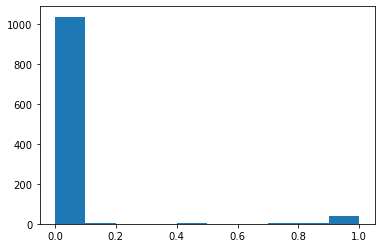

In [63]:
plt.hist(test_preds[0])

In [ ]:
model1 = Model(model.input,model.get_layer('dense_552').output)

In [ ]:
model1.predict([X_feature_test,X_static_test,X_stress_episode_test,
                                       X_activity_episode_test,X_smoking_episode_test,X_quit_episode_test])

In [ ]:
X_static_test[0],X_static_test[-1]

In [ ]:
filepath = './models/episode_model.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=40)
callbacks_list = [es,checkpoint]
train_feature,val_feature,train_static,val_static,train_stress,val_stress, \
train_smoking,val_smoking,train_quit,val_quit,train_activity,val_activity, \
train_y,val_y = train_test_split(train_feature,
                                 train_static,
                                 train_stress,
                                 train_smoking,
                                 train_quit,
                                 train_activity,
                                 train_y,
                                 test_size=.1,stratify=train_y)
# train_y = tf.cast(train_y, tf.float32)
# train_x = tf.cast(train_x, tf.float32)
# val_y = tf.cast(val_y, tf.float32)
# val_x = tf.cast(val_x, tf.float32)
# history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=200, batch_size=30,
#                     verbose=0,callbacks=callbacks_list,shuffle=True)

In [ ]:
model.fit([train_feature,train_static,train_stress,train_activity,train_smoking,train_quit],train_y,
          validation_data=([val_feature,val_static,val_stress,val_activity,val_smoking,val_quit],val_y), epochs=200, batch_size=30,
                    verbose=1,callbacks=callbacks_list,shuffle=True)

In [ ]:
accuracy_score(y_test,
               np.round())

In [ ]:
train_feature.shape[2]

In [ ]:
len(np.unique(final_groups))

In [ ]:
model = get_model(X_train)

In [ ]:
model.summary()

In [ ]:
import uuid
filepath = './models/'+'-'.join([str(n_lag),str(n_groups)])+'-'+str(uuid.uuid4())+'.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=False)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=40)
callbacks_list = [es,checkpoint]
train_x,val_x,train_y,val_y = train_test_split(X_train,y_train,test_size=.2,stratify=y_train)
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=100, batch_size=100,verbose=1,callbacks=callbacks_list,shuffle=True)

In [ ]:
model.load_weights(filepath)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import auc,roc_auc_score,f1_score
roc_auc_score(y_test,y_pred)

In [ ]:
len(np.unique(groups))

In [ ]:
y_train

In [ ]:
tf.Variable(np.arange(10)).numpy()

In [ ]:
len